<a href="https://colab.research.google.com/github/cicily19/Loan_Eligibility_Prediction/blob/main/Loan_illegibility_prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score



In [2]:
df = pd.read_csv('/content/loan_approval_dataset.csv')
print(df.shape)
df.head()



(4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## DATA PREPROCESSING

CLEANING COLUMN NAMES

In [3]:
# Removing spaces from column names
df.columns = df.columns.str.strip()

# Dropping 'loan_id'
df.drop(columns=['loan_id'], inplace=True)

print(df.columns)


Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')


CHECKING MISSING VALUES

In [4]:
print("Missing values per column:")
print(df.isnull().sum())

# Check unique values in categorical columns
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nUnique values in '{col}':", df[col].unique())



Missing values per column:
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Unique values in 'education': [' Graduate' ' Not Graduate']

Unique values in 'self_employed': [' No' ' Yes']

Unique values in 'loan_status': [' Approved' ' Rejected']


CLEANING CATEGORICAL VALUES

In [5]:
# Remove spaces in all object columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.strip())

for col in cat_cols:
    print(f"\nCleaned values in '{col}':", df[col].unique())



Cleaned values in 'education': ['Graduate' 'Not Graduate']

Cleaned values in 'self_employed': ['No' 'Yes']

Cleaned values in 'loan_status': ['Approved' 'Rejected']


LABEL ENCODING OF CATERGORICAL FEATURES

In [6]:
# List of categorical columns to encode
encode_cols = ['education', 'self_employed', 'loan_status']

le = LabelEncoder()
for col in encode_cols:
    df[col] = le.fit_transform(df[col])

df[encode_cols].head()


,education,self_employed,loan_status
0,0,0,0
1,1,1,1
2,0,0,1
3,0,0,1
4,1,1,1


CHECKING FOR INVALID/NEGATIVE ROWS

In [7]:
# Check for any negative values in numeric columns
print("Columns with negative values:")
print((df.select_dtypes(include='number') < 0).any())

#remove rows where residential_assets_value is negative
df = df[df['residential_assets_value'] >= 0]


Columns with negative values:
no_of_dependents            False
education                   False
self_employed               False
income_annum                False
loan_amount                 False
loan_term                   False
cibil_score                 False
residential_assets_value     True
commercial_assets_value     False
luxury_assets_value         False
bank_asset_value            False
loan_status                 False
dtype: bool


SCALING NUMERICAL FEATURES

In [8]:
# Separate features (X) and target (y)
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Initialize scaler
scaler = StandardScaler()

# Scale the feature data
X_scaled = scaler.fit_transform(X)

#mean = 0, std = 1

TRAIN-TEST SPLIT

In [9]:


# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Confirm sizes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (3392, 11)
X_test shape: (849, 11)
y_train shape: (3392,)
y_test shape: (849,)


### SUMMARY OF DATA

In [10]:
# Set decimal display to 2 places
pd.set_option('display.float_format', '{:.2f}'.format)

df.describe()


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4241.00,4241.00,4241.00,4241.00,4241.00,4241.00,4241.00,4241.00,4241.00,4241.00,4241.00,4241.00
mean,2.50,0.50,0.50,5074251.36,15178401.32,10.90,599.69,7522612.59,4985121.43,15171209.62,4991487.86,0.38
std,1.70,0.50,0.50,2803165.67,9034490.27,5.71,172.28,6495800.19,4391503.67,9094716.67,3249493.53,0.48
min,0.00,0.00,0.00,200000.00,300000.00,2.00,300.00,0.00,0.00,300000.00,0.00,0.00
25%,1.00,0.00,0.00,2700000.00,7700000.00,6.00,453.00,2200000.00,1300000.00,7500000.00,2400000.00,0.00
50%,3.00,0.00,1.00,5100000.00,14600000.00,10.00,600.00,5700000.00,3700000.00,14600000.00,4600000.00,0.00
75%,4.00,1.00,1.00,7500000.00,21500000.00,16.00,747.00,11400000.00,7700000.00,21700000.00,7100000.00,1.00
max,5.00,1.00,1.00,9900000.00,39500000.00,20.00,900.00,29100000.00,19400000.00,39200000.00,14700000.00,1.00


### LOAN STATUS DISTRIBUTION

In [11]:
# Count occurrences
df['loan_status'].value_counts()


,count
loan_status,
0,2640
1,1601


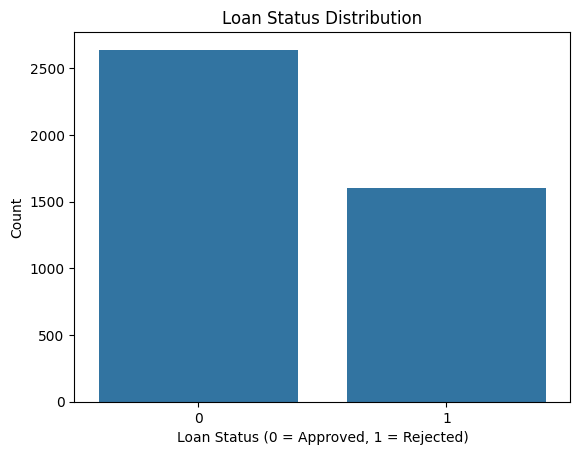

In [12]:

sns.countplot(x='loan_status', data=df)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0 = Approved, 1 = Rejected)')
plt.ylabel('Count')
plt.show()


### MODEL TRAINING


In [13]:
model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

### PREDICTION

In [14]:
y_pred = model.predict(X_test)

X_testSet = pd.DataFrame(X_test, columns=X.columns)

X_testSet.reset_index(drop=True, inplace=True)
y_test_reset = y_test.reset_index(drop=True)


X_testSet['Actual'] = y_test_reset
X_testSet['Predicted'] = y_pred


X_testSet['Predicted_Probability'] = model.predict_proba(X_test)[:, 1]


X_testSet.head(10)


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,Actual,Predicted,Predicted_Probability
0,0.89,1.00,0.99,1.29,1.64,-1.21,-1.33,1.55,2.42,2.14,2.19,0,1,0.88
1,-0.88,-1.00,0.99,-1.17,-1.19,-0.51,0.52,-0.67,-0.57,-1.25,-1.04,0,0,0.01
2,0.89,-1.00,-1.01,-1.70,-1.56,-1.21,-1.40,-1.14,-1.14,-1.56,-1.47,0,1,0.95
3,-0.88,-1.00,0.99,1.40,2.03,1.24,0.74,1.74,1.26,1.42,0.09,0,0,0.01
4,-0.88,-1.00,0.99,1.19,1.22,0.54,0.25,1.83,1.48,0.30,0.59,0,0,0.09
5,-0.29,-1.00,0.99,0.40,0.95,-1.21,-0.64,-0.71,0.57,0.67,-0.52,0,0,0.32
6,-0.29,1.00,-1.01,1.12,1.71,-0.16,-1.49,0.35,1.48,0.19,0.62,1,1,0.98
7,-0.88,-1.00,-1.01,-0.70,-0.51,0.54,0.38,-0.20,-0.95,-0.62,-0.34,0,0,0.04
8,-1.47,1.00,0.99,1.72,2.55,-0.86,-0.15,1.49,1.14,0.54,0.28,0,0,0.08
9,-0.29,-1.00,0.99,-0.45,-0.47,-0.16,0.97,-0.87,-0.25,-0.72,-0.61,0,0,0.00


### EVALUATING MODEL


In [15]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       543
           1       0.89      0.91      0.90       306

    accuracy                           0.92       849
   macro avg       0.92      0.92      0.92       849
weighted avg       0.93      0.92      0.92       849

Confusion Matrix:
 [[508  35]
 [ 29 277]]
ROC AUC Score: 0.97118405373199


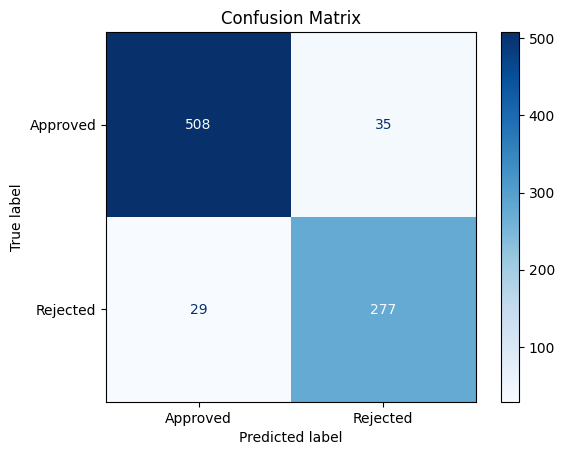

In [16]:
# Visualizing
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Approved", "Rejected"], cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


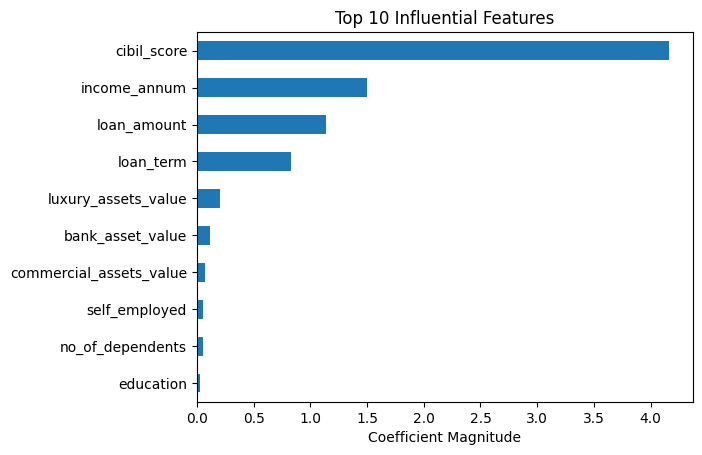

In [17]:
# Model Interpretation
coefficients = pd.Series(model.coef_[0], index=X.columns)
top_features = coefficients.abs().sort_values(ascending=False).head(10)
top_features.plot(kind='barh')
plt.title("Top 10 Influential Features")
plt.xlabel("Coefficient Magnitude")
plt.gca().invert_yaxis()
plt.show()


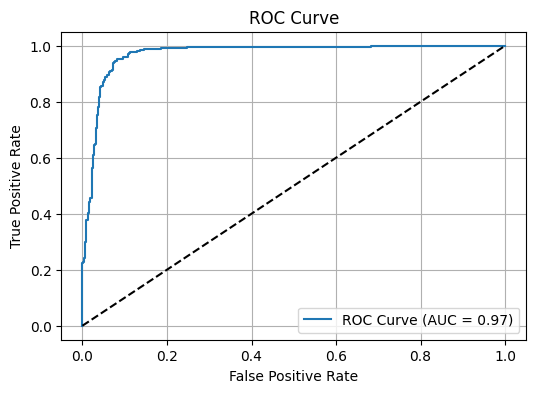

In [18]:
# ROC Curve Plot
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


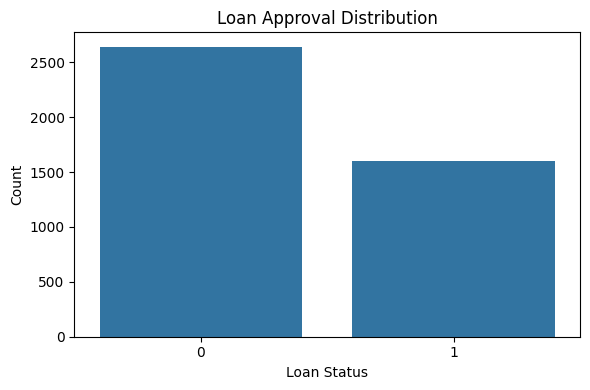

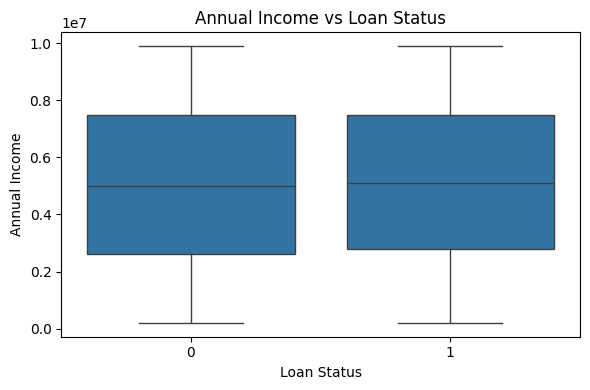

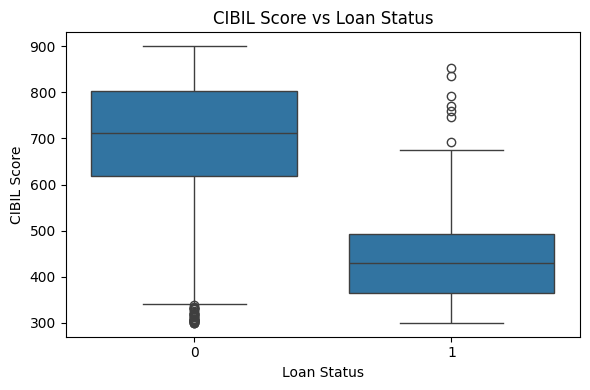

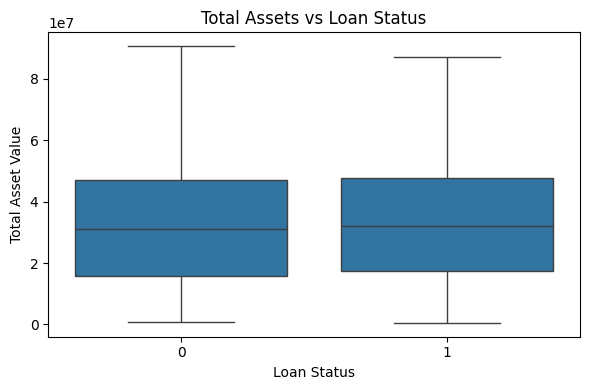

In [19]:
# Descriptive Insights

# 1. Loan Approval Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df)
plt.title('Loan Approval Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Income vs Loan Status
plt.figure(figsize=(6, 4))
sns.boxplot(x='loan_status', y='income_annum', data=df)
plt.title('Annual Income vs Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')
plt.tight_layout()
plt.show()

# 3. CIBIL Score vs Loan Status
plt.figure(figsize=(6, 4))
sns.boxplot(x='loan_status', y='cibil_score', data=df)
plt.title('CIBIL Score vs Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('CIBIL Score')
plt.tight_layout()
plt.show()

# 4. Total Asset Value vs Loan Status
df['total_assets'] = (
    df['residential_assets_value'] +
    df['commercial_assets_value'] +
    df['luxury_assets_value'] +
    df['bank_asset_value']
)

plt.figure(figsize=(6, 4))
sns.boxplot(x='loan_status', y='total_assets', data=df)
plt.title('Total Assets vs Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Total Asset Value')
plt.tight_layout()
plt.show()

# ***Insights - Descriptive***

1. ***Loan Approval Distribution*** - There are more rejected applications than approved ones which implies an imbalanced dataset and possibly stricter loan eligibility criteria.

2. ***Income vs Loan Status*** - Approved applicants tend to have higher income levels than those rejected but income alone is not the sole deciding factor there is some overlap.

3. ***CIBIL Score vs Loan Status*** - Approved applicants generally have higher CIBIL scores.
There's a clear positive correlation between creditworthiness and approval.

4. ***Total Asset Value vs Loan Status*** - Those with more assets (real estate, luxury items, bank funds) are more likely to get approved.
Asset strength contributes significantly to approval decisions.

# ***Insights - Predictive***

1. ***Model Performance*** - ROC_AUC Score = 0.97 : This means that the model has excellent discriminatory power hence outstanding performace.

2.  ***Confusion Matrix Analysis*** -  The true positive rate is approximately 90.5% and the false positive rate is approximately 6.4% indicating that it is low but needs monitoring.

3. ***Classification Report Breakdown*** - There is a very balanced performance for both classes. The model slightly favors approvals but still detects rejections reliably.

4. ***Top Influential Features*** - Key Predictors are CIBIL score, income, loan amount, loan term

5. ***Final Takeaway*** - The model is ready for deployment in automated loan pre-screening systems

# ***Simulation of Model Use Case***

In [20]:
# === Sample New Applicant Data ===
new_applicant = pd.DataFrame([{
    'no_of_dependents': 2,
    'education': 'Graduate',         # 'Graduate' or 'Not Graduate'
    'self_employed': 'No',           # 'Yes' or 'No'
    'income_annum': 8000000,
    'loan_amount': 20000000,
    'loan_term': 10,
    'cibil_score': 780,
    'residential_assets_value': 5000000,
    'commercial_assets_value': 4000000,
    'luxury_assets_value': 6000000,
    'bank_asset_value': 7000000
}])

# === Preprocess Input (Encode & Scale) ===
# Match LabelEncoder encoding
new_applicant['education'] = new_applicant['education'].map({'Graduate': 1, 'Not Graduate': 0})
new_applicant['self_employed'] = new_applicant['self_employed'].map({'Yes': 1, 'No': 0})

# Ensure columns match training data
new_applicant = new_applicant[X.columns]

# Scale with the same scaler used during training
new_applicant_scaled = scaler.transform(new_applicant)

# === Make Prediction ===
prediction = model.predict(new_applicant_scaled)[0]
probability = model.predict_proba(new_applicant_scaled)[0][1]

# === Show Result ===
print("Loan Eligibility Prediction:", "Approved" if prediction == 0 else "Rejected")
print("Model Confidence (Probability of Rejection): {:.2f}%".format(probability * 100))


Loan Eligibility Prediction: Approved
Model Confidence (Probability of Rejection): 0.64%


In [21]:
import joblib

# Save the model, scaler, and feature columns
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns.tolist(), "columns.pkl")


['columns.pkl']

In [22]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load model, scaler, and columns
model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")
columns = joblib.load("columns.pkl")

st.title("Loan Eligibility Predictor 💸")

with st.form("loan_form"):
    no_of_dependents = st.slider("Number of Dependents", 0, 10, 2)
    education = st.selectbox("Education", ["Graduate", "Not Graduate"])
    self_employed = st.selectbox("Self Employed", ["Yes", "No"])
    income_annum = st.number_input("Annual Income", min_value=0, value=8000000)
    loan_amount = st.number_input("Loan Amount", min_value=0, value=25000000)
    loan_term = st.slider("Loan Term (Years)", 1, 30, 10)
    cibil_score = st.slider("CIBIL Score", 300, 900, 750)
    residential_assets = st.number_input("Residential Assets Value", value=5000000)
    commercial_assets = st.number_input("Commercial Assets Value", value=3000000)
    luxury_assets = st.number_input("Luxury Assets Value", value=7000000)
    bank_assets = st.number_input("Bank Asset Value", value=4000000)

    submitted = st.form_submit_button("Predict")

if submitted:
    # Encode categorical
    education = 1 if education == "Graduate" else 0
    self_employed = 1 if self_employed == "Yes" else 0

    # Construct DataFrame
    new_data = pd.DataFrame([{
        'no_of_dependents': no_of_dependents,
        'education': education,
        'self_employed': self_employed,
        'income_annum': income_annum,
        'loan_amount': loan_amount,
        'loan_term': loan_term,
        'cibil_score': cibil_score,
        'residential_assets_value': residential_assets,
        'commercial_assets_value': commercial_assets,
        'luxury_assets_value': luxury_assets,
        'bank_asset_value': bank_assets
    }])[columns]

    # Scale and predict
    scaled = scaler.transform(new_data)
    pred = model.predict(scaled)[0]
    prob = model.predict_proba(scaled)[0][1]

    st.subheader("Prediction:")
    if pred == 0:
        st.success(f"✅ Loan Approved (Confidence of Rejection: {prob:.2%})")
    else:
        st.error(f"❌ Loan Rejected (Confidence of Rejection: {prob:.2%})")


Writing app.py


In [23]:
!pip install streamlit pyngrok --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00


In [28]:
from pyngrok import ngrok
from google.colab import userdata

# Get the ngrok authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

# Set the ngrok authtoken
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Kill any previous tunnels
ngrok.kill()

# Setup tunnel
# Specify the port in a way that should be compatible with the ngrok API
public_url = ngrok.connect(addr=8501, bind_tls=True)
print(f"🔗 Streamlit app is live at: {public_url}")

🔗 Streamlit app is live at: NgrokTunnel: "https://5944-34-133-131-12.ngrok-free.app" -> "http://localhost:8501"


In [25]:
!streamlit run app.py &> /dev/null &
